# Collisional Analysis

[coal]: ../../api_static/plasmapy.collisions.formulary.helio.collisional_analysis.rst
[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101

This notebook will introduce and demonstrate collisional analysis, the functionality is contained in the [collisional_analysis()][coal] module. Collisional analysis, first introduced by [Maruca 2013][maruca2013], uses the idea that Coulomb collisions - "soft," small-angle deflections mediated by the electrostatic force, act to erode non-local thermal equilibrium (LTE) features within the solar wind. Though remnants may persist through much of the inner heliosphere and beyond, this results in strong departures from LTE.

The theory behind this techniquie is detailed below, after which we show how to use the functionality and then apply it to observations. The final section compares observations from the Wind spacecraft with the predictions of this method.


## Contents

1. [Introudction](#Introduction)
2. [Application](#Application)
3. [Comparison](#Comparison)



In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

from astropy import units as u
from hapiclient import hapi

from plasmapy.formulary.collisions.helio import collisional_analysis as coal
from plasmapy.particles import Particle

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

[verscharen2019]: https://doi.org/10.1007/s41116-019-0021-0
[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101
[johnson2023]: https://

## Introduction

The processes by which collisions bring ion temperatures, especially those of protons $(T_{\rm p})$ and $\alpha$-particles $(T_{\alpha})$, into LTE has received considerable attention [Verscharen 2019][verscharen2019]. In situ observations of near-Earth solar wind have shown that the $\alpha$-proton relative temperature,

$$
    \theta_{\alpha \rm p} = \frac{T_{\alpha}}{T_{\rm p}}
$$

varies widely [Johnson 2023][johnson2023]. Collisional analysis allows us to understand how the $\theta_{\alpha \rm p}$ temperature ratio should evolve as a function of distance from the Sun. The derived model from [Maruca 2013][maruca2013] gives the radial gradient in $\theta_{\alpha{\rm p}}$ as,

$$
    \frac{d\theta_{\alpha {\rm p}}}{dr} = \left( \frac{An_{\rm p}}{v_{r\rm p}T^{3/2}_{\rm p}}  \right) \left( \frac{\mu_{\alpha}^{1/2}Z^{2}_{\alpha}(1 - \theta_{\alpha {\rm p}})(1 + \eta_{\alpha {\rm p}} \theta_{\alpha {\rm p}})}{(\mu_{\alpha} + \theta_{\alpha {\rm p}})^{3/2}} \right) \lambda_{\alpha \rm p} \ ,
$$

where

$$
   \lambda_{\alpha \rm p} = 9 + \ln \left[ B \left( \frac{T^{3/2}_{\rm p} (\mu_{\alpha} + \theta_{\alpha {\rm p}})}{n^{1/2}_{\rm p}Z_{\alpha}(1 + \mu_{\alpha})} \right) \left( 1 + \frac{Z^{2}_{\alpha} \eta_{\alpha \rm p} }{\theta_{\alpha {\rm p}}} \right)^{-1/2} \right] \ ,
$$


In these equations, $A = 2.60 \times 10^{7} \, {\rm cm}^{3} \, {\rm km} \, {\rm K}^{3/2} \, {\rm s}^{-1} \, {\rm au}^{-1}$, $B = 1 \, {\rm cm}^{-3/2}{\rm K}^{-3/2} $, $Z_\alpha \equiv q_\alpha/q_{\rm p} = 2$ is the $\alpha$-proton relative charge, $\mu_\alpha \equiv m_\alpha/m_{\rm p} \approx 4$ is their relative mass, and $\eta_{\alpha{\rm p}} \equiv n_\alpha/n_{\rm p}$ is the their relative abundance.

<div class="alert alert-info">

Assumptions

This model assumed the following conditions:

  * $\eta_{\alpha \rm p}$ remains fixed within any given parcel of plasma
  * The system is in a steady state
  * No relative drift between ion species
  * All particles are fully ionized

</div>



We can model how the temperature ratio changes over distance, this allows us to produce characteristic decay curves for two ion species due to the thermalization. Essentially, predicting the temperature ratio for the two ion species at a different point in space, depending on the location of observations this can either be closer to the Earth or the Sun.

Let us model and show how the temperature ratio of the ion species evolve as they travel through the heliosphere.

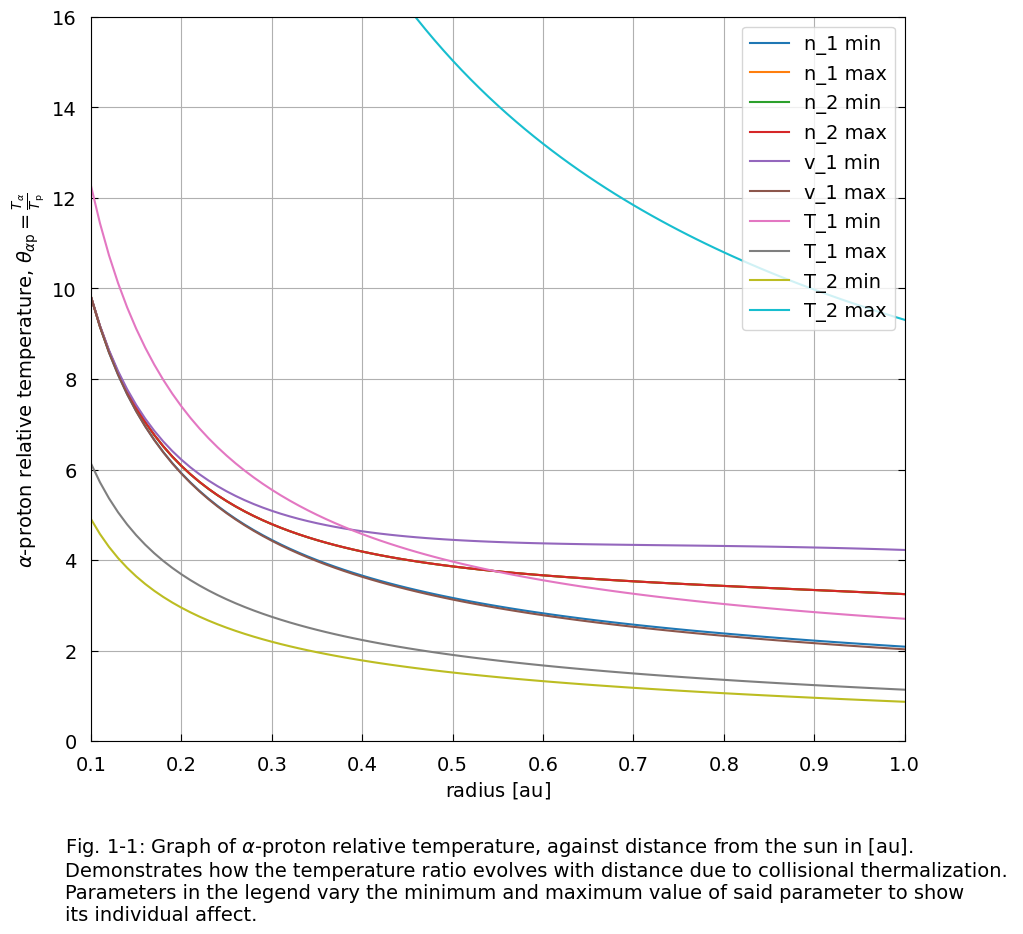

In [6]:
theta = {}

# Define the location, i.e. starting point, at which params were observed in [au]
r_start = 0.1
r_end = 1.1
radii = np.arange(r_start, r_end, 0.01).tolist()

# Define typical values for parameters within the solar wind
n_p_min = 1000
n_p_max = 1500

n_a_min = 5
n_a_max = 15

v_p_min = 350
v_p_max = 450

T_p = 10**5
T_a = 10**6

# Define parameters
params = {
        "r_0": [r_start] * u.au,
        "r_n": [r_end] * u.au,
        "n_1": [random.randint(n_p_min, n_p_max)] * u.cm**-3,
        "n_2": [random.randint(n_a_min, n_a_max)] * u.cm**-3,
        "v_1": [random.randint(v_p_min, v_p_max)] * u.km / u.s,
        "T_1": [(1 + random.random()) * T_p] * u.K,
        "T_2": [(1 + random.random()) * T_a] * u.K,
        "ions": ["p+", "He-4++"],
        "n_step": 100,
    }

# Check values to ensure consistency with observed values
def rand_asgn(params):
    params["n_1"][0] = [random.randint(n_p_min, n_p_max)] * u.cm**-3
    params["n_2"][0] = [random.randint(n_a_min, n_a_max)] * u.cm**-3
    params["v_1"][0] = [random.randint(v_p_min, v_p_max)] * u.km / u.s
    params["T_1"][0] = [random.random() * T_p] * u.K
    params["T_2"][0] = [random.random() * T_a] * u.K

    return params

while params["T_2"][0] / params["T_1"][0] > 15:
    rand_asgn(params)

#Generate minium and maximum values to vary each parameter
mm_vals = {}
mm_vals["n_1"] = (0.8, 5)
mm_vals["n_2"] = (0.5, 10)
mm_vals["v_1"] = (0.6, 10)
mm_vals["T_1"] = (0.8, 2)
mm_vals["T_2"] = (0.8, 3) # change min and max values to be lower and upper

#label the lines indiviaually

# Calculate theta for the given parameters
for param in ("n_1", "n_2", "v_1", "T_1", "T_2"): # Vary certain parameters so we can see their individual affect
    theta[param] = {}
    for mm_val in mm_vals[param]:
        theta[param][mm_val] = []
        params[str(param)][0] = params[str(param)][0] * mm_val
        for radius in radii:
            params["r_n"] = [radius] * u.au
            theta[param][mm_val].append(float(coal.temp_ratio(**params)[0]))

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])


# Show all variations of theta
for param in theta:
    for mm_val in theta[param]:
        if mm_val < 1:
            lbl = "min"
        elif mm_val > 1:
            lbl = "max"

        plt.plot(
            radii,
            theta[param][mm_val], label=f"{str(param)} {lbl}"
        )

# Adjust axes
plt.xlabel(r"radius ${\rm [au]}$", fontsize=fs)
plt.ylabel(
    r"$\alpha$-proton relative temperature, $\theta_{\alpha \rm p} = \frac{T_{\alpha}}{T_{\rm p}}$",
    fontsize=fs,
)

plt.ylim(0, 16)
plt.xlim(0.1, 1)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = r"Fig. 1-1: Graph of $\alpha$-proton relative temperature, against distance from the sun in [au]." f"\nDemonstrates how the temperature ratio evolves with distance due to collisional thermalization. \nParameters in the legend vary the minimum and maximum value of said parameter to show \nits individual affect."

plt.figtext(0.1, -0.08, txt, ha="left", fontsize=fs)
plt.legend(loc="upper right", fontsize=fs)
plt.grid()
plt.show()



[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101
[hellinger2011]: https://doi.org/10.1029/2011JA016674

<div class="alert alert-info">

Note:

The model allows parameters to vary with $r$. In particular, [Maruca 2013][maruca2013] used the following radial scaling based on the analysis of Helios observations by [Hellinger 2011][hellinger2011]:

$$
    n_{\rm p}(r) \propto r^{-1.8}\ , \hspace{1cm} v_{r\rm p}(r) \propto r^{-0.2}\ , \hspace{0.5cm} {\rm and} \hspace{0.5cm} T_{\rm p}(r) \propto r^{-0.74}
$$

These values are not fixed and can be altered within the function, they can be taken from simulations, data or both.

</div>

Looking at the plot, we can see a tendency for the temperature ratio to decrease over distance, in the limit as $r \to \infty$ we can see that $\theta_{\alpha \rm p} \to 1$. The variation in density does not have a major effect on the temperature ratio, this is to be expected as it is assumed that for each parcel of plasma the density ratio, $\eta_{\alpha \rm p} \equiv n_{\alpha}/n_{p}$ remains fixed. The variation in speed shows that slower moving plasma thermalizes quicker than faster moving plasma, though the degree in variation is small. The main parameter that affects the rate of thermalization is the temperature of the secondary ion species, in this case the $\alpha$-particle temperature.


[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101

## Application

This method can be applied to observations from spacecraft, data in this workbook is taken from CDA Web NASA.


To do this we shall create a probability distribution of $\alpha$-proton relative temperature for a data set. The data are sorted among 45 bins ranging from $\theta_{\alpha \rm}$ = 0 to 10, the count of the number of data in each bin was divided by the total number of data, and the $\theta_{\alpha \rm}$-width of the bin to approximate probability density [Maruca 2013][maruca2013]. Only protons and $\alpha$-particles are considered: other ion species and electrons are neglected.

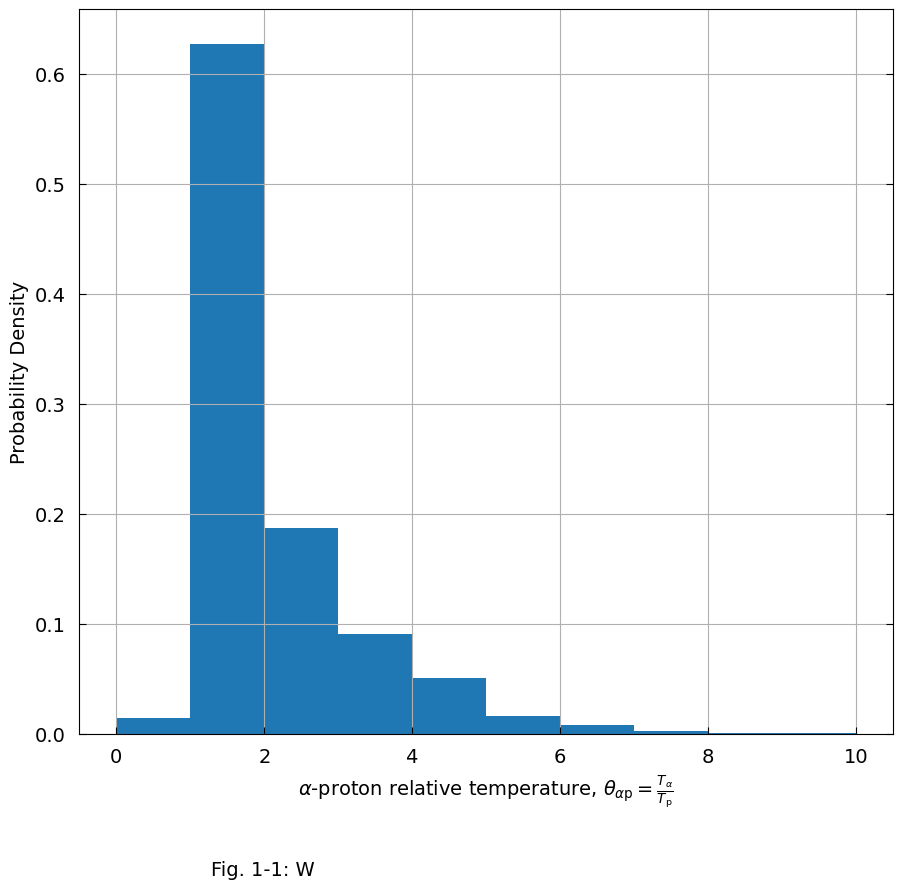

In [7]:
# Get Dst index from CDAWeb HAPI server
server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'HELIOS2_40SEC_MAG-PLASMA'
start      = "1976-09-12T01:21:38Z" #1974-12-12T01:21:38Z
stop       = '1976-11-18T01:21:38Z' #1985-09-04T09:52:10Z

# Get data
time = hapi(server, dataset, 'Time', start, stop)
t_p = hapi(server, dataset, 'Tp', start, stop)
t_a = hapi(server, dataset, 'T_a', start, stop)

# Calculate and clean up theta values
theta = []
for i in range(len(t_p[0])):
    theta.append(t_a[0][i][1]/t_p[0][i][1])

theta = [x for x in theta if str(x) != 'nan']

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

plt.hist(theta, range=(0,10), density=1)

# Adjust axes
plt.ylabel(r"Probability Density", fontsize=fs)
plt.xlabel(
    r"$\alpha$-proton relative temperature, $\theta_{\alpha \rm p} = \frac{T_{\alpha}}{T_{\rm p}}$",
    fontsize=fs,
)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# plot caption
txt = f"Fig. 1-1: W"

plt.figtext(0.25, -0.04, txt, ha="left", fontsize=fs)
plt.grid()
plt.show()



This histogram shows us what the probability of observing a specific temperature ratio,

In [8]:
r_n = hapi(server, dataset, 'R_Helio', start, stop)
n_p = hapi(server, dataset, 'Np', start, stop)
n_a = hapi(server, dataset, 'N_a', start, stop)
v_p = hapi(server, dataset, 'Vp', start, stop)

theta_pred = []
L = len(r_n[0])

for i in range(L):
    params = {
            "r_0": [r_n[0][i][1]] * u.au,
            "r_n": [1.0] * u.au,
            "n_1": [n_p[0][i][1]] * u.cm**-3,
            "n_2": [n_a[0][i][1]] * u.cm**-3,
            "v_1": [v_p[0][i][1]] * u.km / u.s,
            "T_1": [abs(t_p[0][i][1])] * u.K,
            "T_2": [abs(t_a[0][i][1])] * u.K,
            "ions": ["p+", "He-4++"],
        }

    theta_pred.append(float(coal.temp_ratio(**params)[0]))
    print('\r', f"{(i / L) * 100:.2f} %", end="")

theta_pred = [x for x in theta_pred if str(x) != 'nan']
print(theta_pred)
# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

plt.hist(theta_pred, range=(0, 10), density=1)
plt.grid()
plt.show()

 7.23 %

KeyboardInterrupt: 


here we introduce the wind data

pyspedas, spacepy, pystat

https://github.com/hapi-server/client-python/blob/master/README.md


what if instead of the alpha particles being heated prefentially, but that the protons are under heated.
by this i mean that because there are so many of them, some are not heated and this disparity between the heated and underheated ions is what is causing the behaviour.

[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101

## Comparision

Now that we have made a prediction, we can compare it with the actual observed values from the Wind spacecraft.

In [ ]:
# Get data from Wind
dataset    = 'WI_PM_3DP'
start      = "1996-11-01T01:21:38" #1994-11-15T12:53:43Z
stop       = '1996-11-05T01:21:38' #2023-04-24T23:59:58Z

# Get data
time = hapi(server, dataset, 'Time', start, stop)
t_p = hapi(server, dataset, 'P_TEMP', start, stop)
t_a = hapi(server, dataset, 'A_TEMP', start, stop)

theta = []
for i in range(len(t_p[0])):
    theta.append(t_a[0][i][1]/t_p[0][i][1])

theta = [x for x in theta if str(x) != 'nan']

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

plt.hist(theta, range=(0,10), density=1)

plt.show()
